<a href="https://colab.research.google.com/github/ldelacue/git-papers/blob/master/glm_Correct_vs_Incorrect_2_Choose_by_RT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Correct vs Incorrect

In [2]:
!pip install --quiet git+https://github.com/rodjfg/los-fabulosos-pixelotls

In [3]:
from los_fabulosos_pixelotls.tools import load_raw_data, select_by_areas, select_by_contrast, select_trials, calculate_mean_firing_rate, select_by_response
import numpy as np
import math
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
# get data
alldat = load_raw_data()

In [5]:
def select_by_outcome(dat, feedback_type: str = 'correct'):
    '''Find indices of trials with the specified outcome (correct, incorrect) in the dataset provided from a single experiment. 
       Correct = Rewarded, Incorrect = punished. Note that succesful no-go trials indices are also included.
    Args:
        dat (dict): data dictionary from a single experiment. For example dat = alldat[11] in the example notebook.
        feedback_type (str): str specifying outcome. "correct", "incorrect"
    Returns:
        indices (1D array): array of indices from trials.'''

    if feedback_type == 'correct':
        indices = np.where(dat['feedback_type'] > 0)[0]
    elif feedback_type == 'incorrect':
        indices = np.where(dat['feedback_type'] < 0)[0]
  
    else:
        raise Warning('wrong response_type input, choose: correct or incorrect')

    return indices

In [6]:
#selected_regions = ["MB"]
#selected_regions = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]
selected_regions = ["VISL"]


gaussfilter = True
gauss_sigma = 1

  #zscore the neuron responses

def zscore(data_to_normalize, window= [0,250]):

   """
   For each time bin of a given neuron spike train (data_to_normalize), substract
   the mean over a given window (by default set to the whole trial 
   duration) and divide it over the STD. 
   
   A z-score can then essentially show what multiple of standard deviation a
   firing rate is above the mean.
   """
   ZscoredData     = np.zeros((len(data_to_normalize),len(data_to_normalize.T)))
   AllMean         = np.zeros(len(data_to_normalize))
   AllSTD          = np.zeros(len(data_to_normalize))
   for neur in range(len(data_to_normalize)):

    mean_window = np.mean(data_to_normalize[neur,:window[-1]+1])
    std_window  = np.std(data_to_normalize[neur,:window[-1]+1]) + np.finfo(float).eps


    ZscoredData[neur]  = ((data_to_normalize[neur] - mean_window) / std_window)
    AllSTD[neur] = std_window
    AllMean[neur] = mean_window

    return ZscoredData, AllMean, AllSTD

   #select by reaction times

def select_by_response_win(dat, which_win: str = 'after', threshold = 1.5):

    '''Find indices of trials with a reaction time above or below the one indicated at threshold.
    Args:
        dat (dict): data dictionary from a single experiment. For example dat = alldat[11] in the example notebook.
    Returns:
        indices (1D array): array of indices from trials.'''

    if which_win == 'after':
        indices = np.where(dat['response_time'] >= threshold)[0]
    elif which_win == 'before':
        indices = np.where(dat['response_time'] <= threshold)[0]
  
    return indices



samples = np.empty((0,125))
y = np.empty((0,))

for dat in alldat:
  dt = dat['bin_size']

  neurons_indices_in_area = select_by_areas(dat, selected_regions = selected_regions)

  #BinGoCue     = (dat['gocue']*100).astype(int)
  #BinGoCue     = (50+dat['gocue']*100).astype(int)
  #BinGoCue     = (50+dat['feedback_time']*100).astype(int)

  
  if len(neurons_indices_in_area) > 0:
    after_trials = select_by_response_win(dat, which_win = 'after', threshold = 2.2)
    
    total_correct_trials   = select_by_outcome(dat, feedback_type = 'correct')   # trials in which mouse was correct   (trials in which the animals was reinforced, water reward)
    
    total_incorrect_trials = select_by_outcome(dat, feedback_type = 'incorrect') # trials in which mouse was incorrect (trials in which the animals was punished, whit noise burst)
    no_go_trials     = select_by_contrast(dat, contrast_pair = (0, 0))     # no-go trials indices
   

    correct_trials   = [x for x in total_correct_trials if x in after_trials]   # we exclude no go trials
    incorrect_trials = [x for x in total_incorrect_trials if x in after_trials] # we exclude no go trials
    

    # BinnedCorrect = BinGoCue[correct_trials]
    # BinnedIncorrect = BinGoCue[incorrect_trials]
    # Binned_correct_firing_rates = np.empty((0,250))
    # Binned_incorrect_firing_rates = np.empty((0,250))

    # for trial in 
    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the left


    correct_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,correct_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)

    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the right
    incorrect_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,incorrect_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)
    
    # for i, trial in enumerate(BinnedCorrect):
   
    #   Unimportant_name1   = correct_firing_rates[i, trial[0]-80:trial[0]+0]
    #   Binned_correct_firing_rates   = np.concatenate((Binned_correct_firing_rates,Unimportant_name1[np.newaxis,:]),axis = 0)

    # for i, trial in enumerate(BinnedIncorrect):
    #   Unimportant_name2   = incorrect_firing_rates[i, trial[0]-80:trial[0]+0]
    #   Binned_incorrect_firing_rates   = np.concatenate((Binned_incorrect_firing_rates,Unimportant_name2[np.newaxis,:]),axis = 0)
    # correct_firing_rates   = Binned_correct_firing_rates 
    # incorrect_firing_rates = Binned_incorrect_firing_rates 
    # Find minimum number of samples that can be extracted from both conditions:
    
    # ALternative 1, we feed the model with equal number of positive and negative trials  # Thus, we find which
    #one is the limitting condition and select only as many trials from the non-limiting condition. (this reduces our dataset substantially) 
    time_window = np.arange(0,250,2)

    n_min   = min(correct_firing_rates.shape[0],incorrect_firing_rates.shape[0])
    samples = np.concatenate((samples,correct_firing_rates[:n_min,time_window]),axis=0)  
    samples = np.concatenate((samples,incorrect_firing_rates[:n_min,time_window]),axis=0)

    y = np.concatenate( (y, np.ones(n_min)) )
    y = np.concatenate( (y, np.zeros(n_min)) )

    #print(math.floor(dat['gocue']*10))
    
    # Alternative 2, we feed the model with all the trials. This teaches better the model to recognise correct than incorrect trials.
    # samples = np.concatenate((samples,correct_firing_rates),axis=0)
    # samples = np.concatenate((samples,incorrect_firing_rates),axis=0)
    
    # # Create output variable to train the GLM. 1: when mouse was correct, 0: when mouse was incorrect
    # y = np.concatenate( (y, np.ones(correct_firing_rates.shape[0])) )
    # y = np.concatenate( (y, np.zeros(incorrect_firing_rates.shape[0])) )
    # # Create output variable to train the GLM. 1: when mouse was correct, 0: when mouse was incorrect
    #print(len(no_go_trials),len(correct_trials),len(incorrect_trials))
    #print(y.shape)
# print(AllMeanSTD[:])

In [103]:
# print((correct_firing_rates.shape))
# print(np.min([(BinnedCorrect)]))
# print(np.max([(BinnedCorrect)]))
# print(len(BinnedCorrect))
# print(np.min([(BinnedIncorrect)]))
# print(np.max([(BinnedIncorrect)]))

# print(samples.shape)
# print(a[0][:-70]+50)
# plt.hist(a[0][:-70]+50)


# print(dat['gocue'][0:10])
# print(dat['feedback_time'][0:10])
print(len(total_correct_trials),len(correct_trials), len(total_incorrect_trials), len(incorrect_trials))


246 16 97 5


(array([41., 50., 63., 42., 11.,  8.,  7., 10., 63., 48.]),
 array([0.51433742, 0.69619435, 0.87805127, 1.05990819, 1.24176512,
        1.42362204, 1.60547896, 1.78733589, 1.96919281, 2.15104973,
        2.33290666]),
 <a list of 10 Patch objects>)

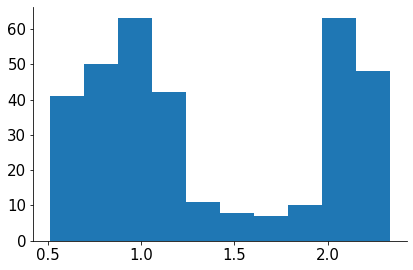

In [95]:
#  counts, bins = np.histogram(dat['gocue'])
#plt.hist(bins[:-1], bins, weights=counts)
#print(correct_firing_rates.shape)
#plt.hist(dat['feedback_time'][after_trials] )
plt.hist(dat['feedback_time'] )

#print(dat['reaction_time'])
#counts, bins = np.histogram(BinGoCue)
#plt.hist(bins[:-1], bins, weights=counts)
#print(correct_firing_rates.shape)

In [57]:
print(neurons_indices_in_area[1].shape)
print(dat['spks'].shape)


()
(1348, 343, 250)


In [34]:
y.shape, samples.shape

((612,), (612, 250))

TRAIN AND TEST SPLIT

In [7]:
samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.30, random_state=42)


#samples_train, AllMean, AllSTD = zscore(samples_train, window = [0,80] )

#print(AllMean[2:5],AllSTD[2:5],samples_train[3:6])

#samples_test, AllMeanBaseline, AllMeanSTD = zscore(samples_test, window = [0,80] )
print(BinnedCorrect[0])
print(BinnedCorrect[1],BinnedCorrect[2],BinnedCorrect[3],BinnedCorrect[4])



ValueError: ignored

In [ ]:
# C: float, default=1.0, Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
clf = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train) # crossvalidation
#clf = LogisticRegressionCV(Cs=5, cv=4, penalty='l1', solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train) # crossvalidation


In [ ]:
clf.score(samples_test,y_test)

In [ ]:
clf.score(samples_train,y_train)

In [ ]:
print(clf.C_) # OPtimal C value as specified with Crossvalidation

In [ ]:
plt.subplot(211)
plt.plot(clf.coef_[0,:])
plt.subplot(212)
plt.plot(np.abs(clf.coef_[0,:]))
plt.show()

In [64]:
def clasificator_analisis(model, X, y):
  '''Compute accuracy with CV, confusion matrix, precision-recall scores and plot ROC and precision-recall curves.
   Args: 
     model = model object trained from sklearn
         X = input features in train or test
         y = target in train or test
   Return:
    Print of all the scores computed and save accuracy, cm, precision, recall
'''
  
  from sklearn.model_selection import cross_val_predict, cross_val_score
  from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve

  #accu = cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
  #print(f'{model} \nAccuracy:{accu}\n')
  pred = model.predict(X)
  cm = confusion_matrix(y,pred)
  print(f'Confusion Matrix: \n {cm}\n')
  precision = precision_score(y,pred)
  print('Precision:',precision)
  recall = recall_score(y, pred)
  print('Recall:', recall)
  plot_precision_recall_curve(model, X, y)
  plt.show()

  plot_roc_curve(model, X, y)
  plt.plot([0, 1], [0, 1], color='0.5', ls=':')
  plt.show()


Confusion Matrix: 
 [[283 154]
 [131 267]]

Precision: 0.6342042755344418
Recall: 0.6708542713567839


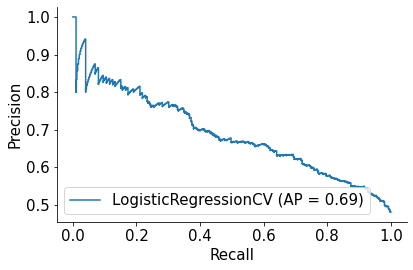

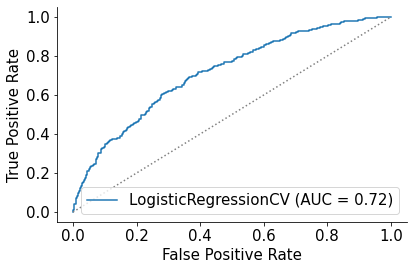

In [65]:
clasificator_analisis(clf, samples_test, y_test)

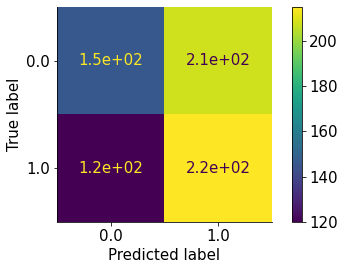

In [100]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, samples_test, y_test)
